# Visualization

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

from package.detection import *

import copy

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


## General Outlier Identification

In [3]:
lab = pd.read_csv('./dataset/label.csv', sep=';', index_col=0).values.ravel()

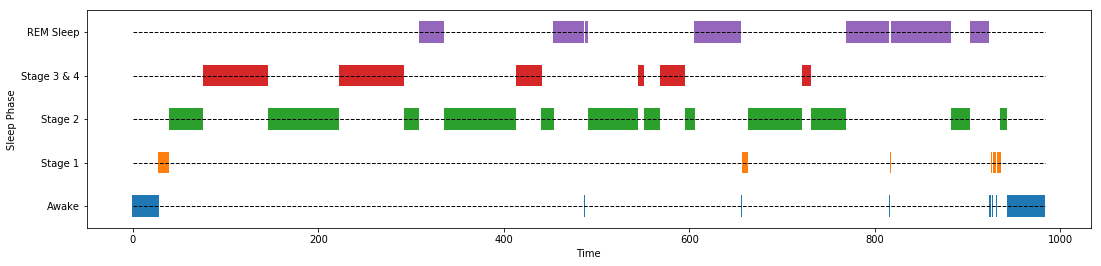

In [6]:
dis = Profiles(lab)
prf, mkr = dis.build_profiles()
dis.display_profile(prf[-16])

In [3]:
import h5py

e_key = ['eeg_{}'.format(dim) for dim in range(1, 5)]

with h5py.File('./dataset/train.h5', 'r') as dtb:
    eeg_t = np.asarray([dtb[key].value for key in e_key])

with h5py.File('./dataset/valid.h5', 'r') as dtb:
    eeg_v = np.asarray([dtb[key].value for key in e_key])

eeg_s = np.concatenate((eeg_t, eeg_v), axis=1)
del eeg_t, eeg_v

In [4]:
for lvl in range(4):
    msk = np.load('./models/level_{}/row_mask.npy'.format(lvl))
    print('Level', lvl, ':', len(np.where(np.invert(msk))[0]) / len(msk))

Level 0 : 0.0
Level 1 : 0.0831703455341343
Level 2 : 0.14752724224643754
Level 3 : 0.32766756698022415


In [5]:
msk = Anomaly().spot_outliers(update=True, threshold=60)

In [6]:
print('# Amplitudes:', np.max(eeg_s[:,msk,:]), np.min(eeg_s[:,msk]))
print('# General Mask:', len(np.where(np.invert(msk))[0]) / len(msk))
print('# Training Mask:', len(np.where(np.invert(msk[:len(lab)]))[0]) / len(msk[:len(lab)]))
print('# Testing Mask:', len(np.where(np.invert(msk[len(lab):]))[0]) / len(msk[len(lab):]))

# Amplitudes: 10196.428 -10187.349
# General Mask: 0.0831703455341343
# Training Mask: 0.07905544147843943
# Testing Mask: 0.09192890442890443


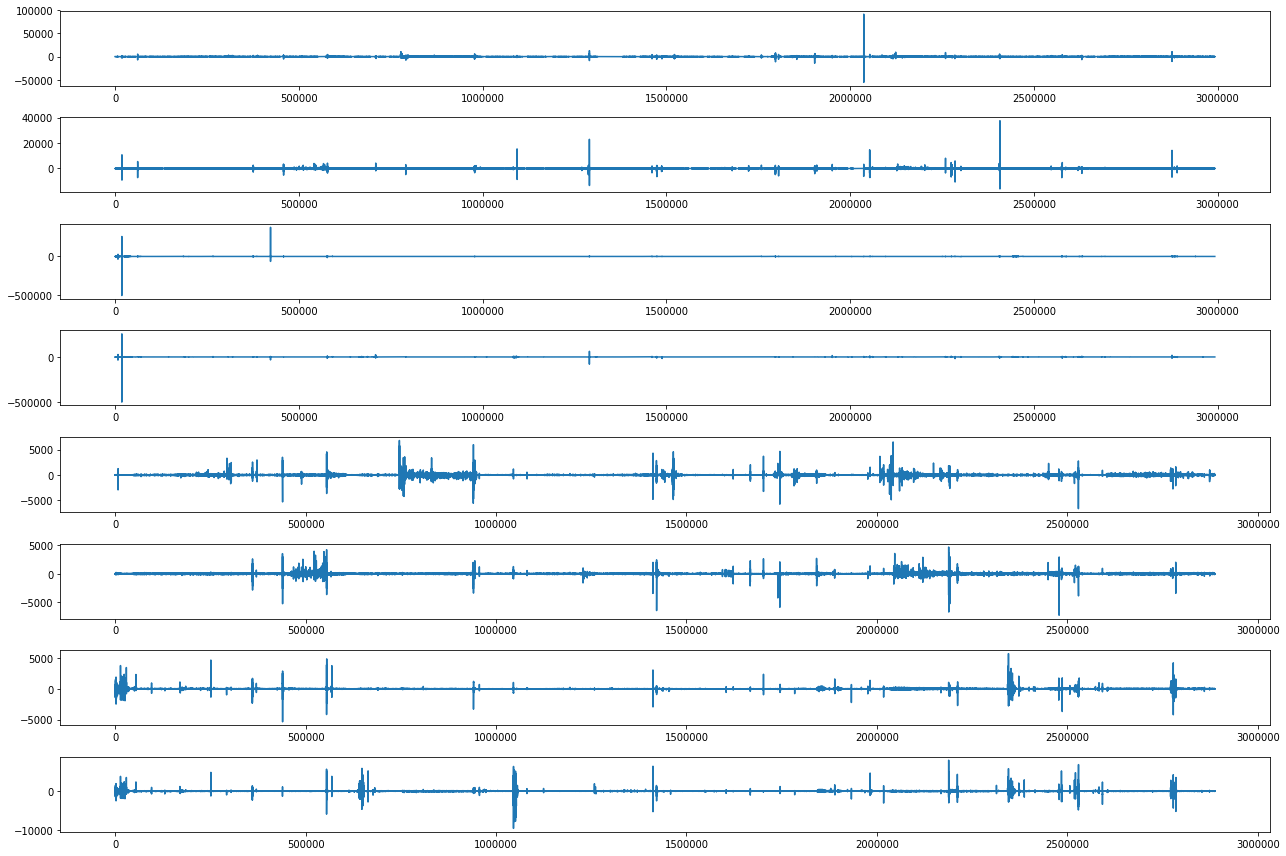

In [9]:
beg, end = mkr[np.random.choice(np.arange(len(mkr)))]

plt.figure(figsize=(18,12))
for i in range(4):
    plt.subplot(8,1,i+1)
    plt.plot(np.hstack(tuple(eeg_s[i,beg:end,:])))
for i in range(4, 8):
    plt.subplot(8,1,i+1)
    plt.plot(np.hstack(tuple(eeg_s[i-4,beg:end,:][msk[beg:end]])))
plt.tight_layout()
plt.show()

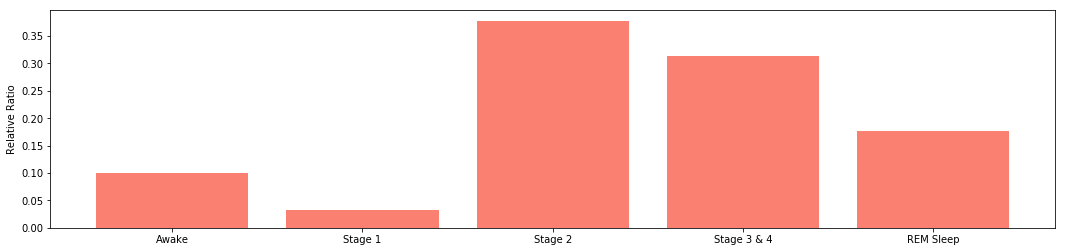

In [10]:
Profiles(lab[msk[:len(lab)]]).ratios()

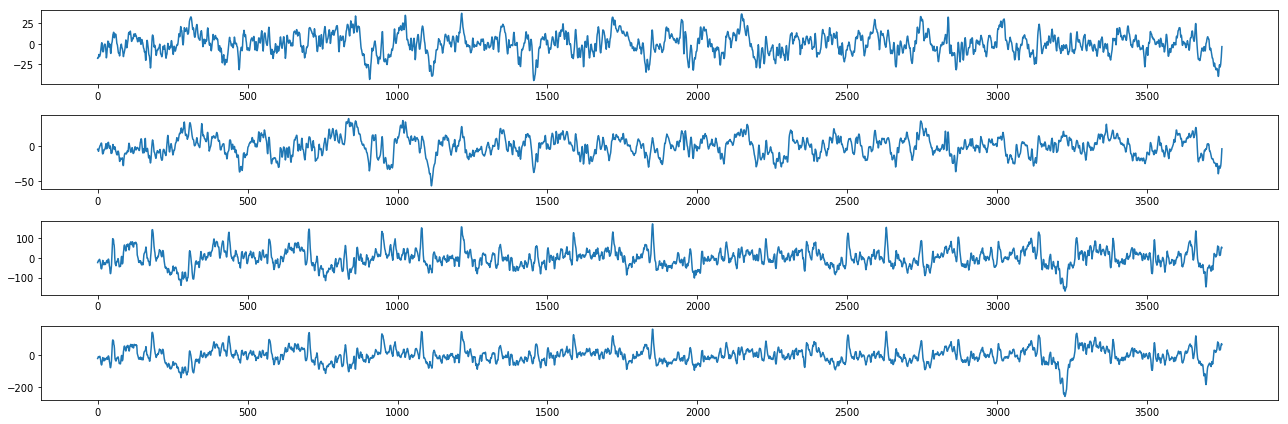

In [13]:
tmp = eeg_s[:,np.random.choice(np.where(msk)[0]),:]

plt.figure(figsize=(18,6))
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.plot(tmp[i,:])
plt.tight_layout()
plt.show()

## Linear Feature Development

In [23]:
lab = pd.read_csv('./dataset/label.csv', sep=';', index_col=0).values.ravel()
msk = np.load('./models/level_0/row_mask.npy')[:len(lab)]
y_t = lab[msk[:len(lab)]]
x_t = np.load('./dataset/fea_train.npy')[msk[:len(lab)]]

In [24]:
vtf = VarianceThreshold()
x_t = vtf.fit_transform(x_t)
mms = MinMaxScaler()
sts = StandardScaler(with_std=False)
pip = Pipeline([('mms', mms), ('sts', sts)])
x_t = pip.fit_transform(x_t)

In [25]:
columns = np.asarray(joblib.load('./dataset/features.jb'))
dtf = pd.DataFrame(x_t, columns=columns[vtf.get_support()])

100%|████████████████████████████████████████████████████████████| 1080/1080 [00:00<00:00, 1381.66it/s]


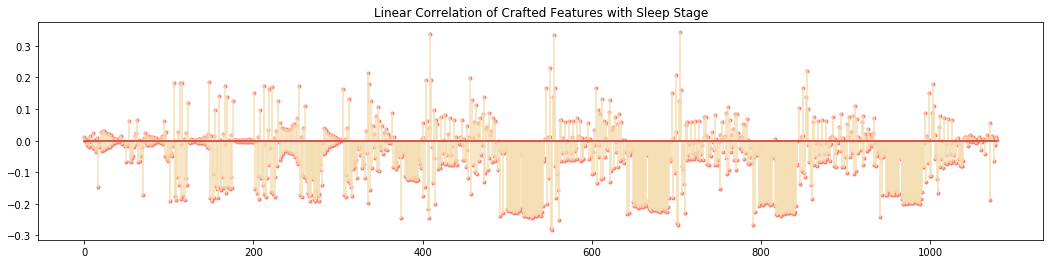

In [19]:
import tqdm
from scipy.stats import pearsonr

coe = np.asarray([pearsonr(y_t, x_t[:,col])[0] for col in tqdm.tqdm(range(x_t.shape[1]))])

plt.figure(figsize=(18,4))
plt.title('Linear Correlation of Crafted Features with Sleep Stage')
ish, lns, _ = plt.stem(np.arange(x_t.shape[1]), coe)
_ = plt.setp(ish, markersize=2, markeredgecolor='salmon', markeredgewidth=2.0)
_ = plt.setp(lns, linestyle="-", color='wheat', linewidth=1.5)
plt.show()